<a href="https://colab.research.google.com/github/parlad/AI_Agents/blob/main/NN_Finds_opposite_N_with_least_similarity_no_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Okay, thank you for the clarification! This is a much more specific and very insightful goal. You're not looking for semantic opposites or maximally different things, but rather trying to probe the model's "confusion space" or "similarity landscape."

You want to know: **When the model analyzes an input (like a cat), what *other* classes does it find *partially similar* based on shared features, even if those classes are ultimately ruled out? And specifically, which of these partially similar classes are perhaps the *most distinct* from the input *while still sharing some key features*?**

This involves looking at the classes the model might consider "close calls" or neighbors in its internal feature representation, rather than just the final winner or the absolute losers.

Here's a new approach and code structure designed for this goal, focusing on analyzing similarities in the **feature space**:

**Concept:**

1.  **Feature Extraction:** Use a pre-trained model (like ResNet50) not just for classification, but to extract the high-dimensional feature vector for an input image (typically the output of the layer *before* the final classification layer). This vector captures the essence of the image as understood by the model.
2.  **Reference Vectors:** We need a set of reference points. The best way is often to pre-calculate the *average* feature vector for each of the 1000 ImageNet classes using a large set of images (like the ImageNet validation set).
3.  **Similarity Search (Nearest Neighbors):** Calculate the similarity (e.g., using cosine similarity) between the input image's feature vector and the average feature vector of *every* ImageNet class.
4.  **Analyze Neighbors:** Instead of just taking the most similar class (which should be the correct prediction), examine the classes ranked #2, #3, #4, etc., in terms of feature similarity. These are the classes the model "sees" as most similar to the input based on shared learned features.
5.  **Find "Least Similar Among the Similar":** From this list of neighbors (e.g., ranks 2 through 15), you can identify those that are further down the list. These represent classes that share *some* features (enough to be considered neighbors) but are less similar than the very closest matches (like different breeds of cats). This addresses your goal of finding things like tigers or leopards when searching for a cat – they share features but are distinct.

**Code Structure (Conceptual - Requires Pre-computation Step):**

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


ResNet50 feature extractor loaded.
Labels downloaded.
Loaded 1000 ImageNet labels.
ERROR: Average feature vector file ('imagenet_avg_feature_vectors.npy') not found.
This file must be pre-computed by running the feature extractor
over the ImageNet validation set and averaging vectors per class.
Cannot proceed without it.

--- Analyzing Neighbors for: https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/640px-Cat03.jpg ---

Input Image (displaying):


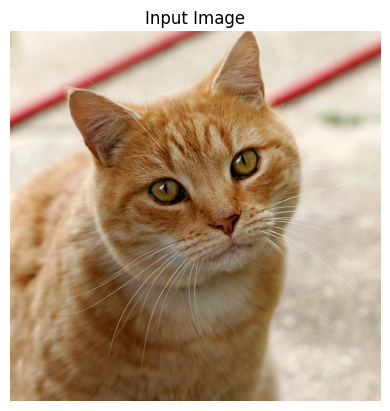


Top 15 Most Similar Classes (based on feature vectors):
  Rank 1: billiard table (Similarity: 0.6434)
  Rank 2: horse-drawn vehicle (Similarity: 0.6419)
  Rank 3: oil filter (Similarity: 0.6418)
  Rank 4: Alpine ibex (Similarity: 0.6403)
  Rank 5: kimono (Similarity: 0.6402)
  Rank 6: hummingbird (Similarity: 0.6400)
  Rank 7: oxygen mask (Similarity: 0.6400)
  Rank 8: parachute (Similarity: 0.6389)
  Rank 9: bee eater (Similarity: 0.6389)
  Rank 10: hatchet (Similarity: 0.6385)
  Rank 11: Granny Smith (Similarity: 0.6384)
  Rank 12: doormat (Similarity: 0.6378)
  Rank 13: tool kit (Similarity: 0.6378)
  Rank 14: broom (Similarity: 0.6369)
  Rank 15: vase (Similarity: 0.6367)

--- Interpretation ---
The list above shows classes the model finds similar in *feature space*.
The top result (Rank 1: 'billiard table') is likely the correct class or a very close relative.
Classes ranked lower (e.g., Rank 2-10) share *some* features with the input,
representing the 'similarity landscape' or '

In [1]:
# --- Step 1: Setup and Imports ---
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
import json
import numpy as np
from scipy.spatial.distance import cosine # For cosine similarity/distance
import matplotlib.pyplot as plt
import os
import time # For timing precomputation

# --- Step 2: Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
NUM_CLASSES = 1000
FEATURE_VECTOR_SIZE = 2048 # For ResNet50's avgpool output
NEIGHBORS_TO_SHOW = 15 # How many top similar classes to analyze (including the top-1)

# --- Step 3: Load Pre-trained Model (as Feature Extractor) ---
# Load ResNet50
weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)

# --- IMPORTANT: Modify model to output features before the final layer ---
# We want the output of the 'avgpool' layer for ResNet50
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]) # Remove the final fc layer
feature_extractor.eval()
feature_extractor.to(device)
print("ResNet50 feature extractor loaded.")

# --- Step 4: Load ImageNet Class Labels ---
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
LABELS_PATH = "imagenet_simple_labels.json"
if not os.path.exists(LABELS_PATH):
    print("Downloading ImageNet labels...")
    response = requests.get(LABELS_URL)
    response.raise_for_status()
    with open(LABELS_PATH, 'w') as f: f.write(response.text)
    print("Labels downloaded.")
with open(LABELS_PATH) as f:
    labels = json.load(f)
print(f"Loaded {len(labels)} ImageNet labels.")

# --- Step 5: Load Pre-computed Average Class Feature Vectors ---
# !!! CRUCIAL PRE-COMPUTATION STEP !!!
# This file needs to be generated beforehand by processing the ImageNet
# validation set (or a large subset) through the feature_extractor.
AVG_VECTORS_PATH = "imagenet_avg_feature_vectors.npy"
AVG_VECTORS_LABELS_PATH = "imagenet_avg_feature_vectors_labels.json" # Store labels corresponding to vectors

# Check if the pre-computed file exists
if not os.path.exists(AVG_VECTORS_PATH) or not os.path.exists(AVG_VECTORS_LABELS_PATH):
    print(f"ERROR: Average feature vector file ('{AVG_VECTORS_PATH}') not found.")
    print("This file must be pre-computed by running the feature extractor")
    print("over the ImageNet validation set and averaging vectors per class.")
    print("Cannot proceed without it.")
    # In a real scenario, you would exit or run the pre-computation here.
    # For demonstration, we'll create placeholder data IF we were to run pre-computation.
    # raise FileNotFoundError("Missing pre-computed average feature vectors.") # Halt execution
    avg_class_vectors = np.random.rand(NUM_CLASSES, FEATURE_VECTOR_SIZE).astype(np.float32) # Placeholder
    avg_class_labels = labels[:NUM_CLASSES] # Placeholder
    print("WARNING: Using random placeholder data for average vectors.")
else:
    print(f"Loading pre-computed average feature vectors from {AVG_VECTORS_PATH}...")
    avg_class_vectors = np.load(AVG_VECTORS_PATH)
    with open(AVG_VECTORS_LABELS_PATH, 'r') as f:
        avg_class_labels = json.load(f) # Load the labels in the order vectors were saved
    print(f"Loaded {avg_class_vectors.shape[0]} average feature vectors.")
    # Basic validation
    if avg_class_vectors.shape[0] != len(avg_class_labels) or avg_class_vectors.shape[1] != FEATURE_VECTOR_SIZE:
         raise ValueError("Mismatch in loaded average vectors shape or labels.")

# --- Step 6: Image Preprocessing (Matches model training) ---
preprocess = weights.transforms()

# --- Step 7: Helper Functions ---
def load_image_from_url(url):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(response.raw).convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

def show_image(image, title=""):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_feature_vector(image, model, device, preprocess_fn):
    """Extracts feature vector for a single image."""
    if image is None:
        return None
    input_tensor = preprocess_fn(image)
    input_batch = input_tensor.unsqueeze(0).to(device) # Add batch dimension

    with torch.no_grad():
        features = model(input_batch)
        # Flatten the output (output shape is [1, feature_size, 1, 1])
        feature_vector = torch.flatten(features, 1)

    return feature_vector.cpu().numpy() # Return as numpy array on CPU

# --- Step 8: The Core Logic - Find Similar Classes in Feature Space ---

def find_feature_neighbors(image_url, feature_extractor_model, avg_vectors, avg_labels, device, preprocess_fn, k=10):
    """
    Finds the top k most similar classes based on feature vector cosine similarity.
    Returns a list of tuples: (label, similarity_score)
    """
    print(f"\n--- Analyzing Neighbors for: {image_url} ---")
    input_image = load_image_from_url(image_url)
    if input_image is None: return None

    # Get feature vector for the input image
    input_vector = get_feature_vector(input_image, feature_extractor_model, device, preprocess_fn)
    if input_vector is None: return None
    input_vector = input_vector.flatten() # Ensure it's 1D

    # Calculate cosine similarity between input vector and all average class vectors
    # Cosine distance = 1 - cosine similarity
    similarities = []
    for i, avg_vec in enumerate(avg_vectors):
        # Ensure avg_vec is also 1D
        avg_vec_flat = avg_vec.flatten()
        # Calculate cosine similarity (higher is better)
        # Avoid division by zero if vector norm is zero
        norm_input = np.linalg.norm(input_vector)
        norm_avg = np.linalg.norm(avg_vec_flat)
        if norm_input == 0 or norm_avg == 0:
            similarity = 0.0
        else:
            similarity = np.dot(input_vector, avg_vec_flat) / (norm_input * norm_avg)

        similarities.append((avg_labels[i], similarity)) # Store label and similarity

    # Sort by similarity (descending - most similar first)
    similarities.sort(key=lambda x: x[1], reverse=True)

    print(f"\nInput Image (displaying):")
    show_image(input_image, "Input Image")

    print(f"\nTop {k} Most Similar Classes (based on feature vectors):")
    results = []
    for i in range(min(k, len(similarities))):
        label, score = similarities[i]
        print(f"  Rank {i+1}: {label} (Similarity: {score:.4f})")
        results.append((label, score))

    return results

# --- Step 9: Run Example ---

# Example: Input a cat image
cat_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/640px-Cat03.jpg"
neighbors = find_feature_neighbors(cat_url,
                                  feature_extractor,
                                  avg_class_vectors,
                                  avg_class_labels,
                                  device,
                                  preprocess,
                                  k=NEIGHBORS_TO_SHOW)

# --- Step 10: Interpreting the Results (Focus of the User's Request) ---
if neighbors:
    print("\n--- Interpretation ---")
    print("The list above shows classes the model finds similar in *feature space*.")
    print(f"The top result (Rank 1: '{neighbors[0][0]}') is likely the correct class or a very close relative.")
    print("Classes ranked lower (e.g., Rank 2-10) share *some* features with the input,")
    print("representing the 'similarity landscape' or 'confusion space' you asked about.")
    print("These might include related animals (like tigers, leopards if input is cat),")
    print("different breeds, or objects with similar textures/shapes.")

    # Select the "least similar among the similar" - e.g., ranks 5-10
    start_rank_least_similar = 5
    end_rank_least_similar = 10 # Adjust as needed
    print(f"\nPotential 'Least Similar Things From Its Search' (e.g., Ranks {start_rank_least_similar}-{end_rank_least_similar}):")
    if len(neighbors) >= start_rank_least_similar:
        for i in range(start_rank_least_similar - 1, min(end_rank_least_similar, len(neighbors))):
             label, score = neighbors[i]
             print(f"  Rank {i+1}: {label} (Similarity: {score:.4f})")
    else:
        print(f"  (Not enough neighbors found to show ranks {start_rank_least_similar}-{end_rank_least_similar})")


# --- Appendix: Code for Pre-computing Average Vectors (Run Once) ---
# This part would be run separately on a machine with access to ImageNet validation set

def precompute_average_vectors(imagenet_val_path, model, device, preprocess_fn, output_vec_path, output_label_path):
    """
    Computes average feature vector for each ImageNet class.
    Requires ImageNet validation set structured like:
    imagenet_val_path/n01440764/ILSVRC2012_val_00000293.JPEG
    imagenet_val_path/n01443537/ILSVRC2012_val_00000238.JPEG
    ... (where n... is the WordNet ID/class folder)
    """
    print("Starting pre-computation of average feature vectors...")
    start_time = time.time()

    # Use ImageFolder dataset - MAKE SURE preprocess_fn matches the one used later!
    try:
        dataset = torchvision.datasets.ImageFolder(imagenet_val_path, transform=preprocess_fn)
        # Use a DataLoader for batching (optional but efficient)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    except FileNotFoundError:
        print(f"ERROR: ImageNet validation path not found: {imagenet_val_path}")
        print("Cannot perform pre-computation.")
        return

    num_images = len(dataset)
    print(f"Found {num_images} images in {len(dataset.classes)} classes.")

    # Dictionary to store sum of vectors and counts per class index
    class_vector_sums = {i: np.zeros(FEATURE_VECTOR_SIZE, dtype=np.float64) for i in range(NUM_CLASSES)}
    class_counts = {i: 0 for i in range(NUM_CLASSES)}

    model.eval() # Ensure model is in eval mode
    processed_images = 0
    with torch.no_grad():
        for inputs, labels_batch in dataloader:
            inputs = inputs.to(device)
            features = model(inputs) # Get features [batch_size, feature_size, 1, 1]
            features = torch.flatten(features, 1).cpu().numpy() # [batch_size, feature_size]

            for i in range(features.shape[0]):
                class_idx = labels_batch[i].item()
                if class_idx < NUM_CLASSES: # Safety check
                    class_vector_sums[class_idx] += features[i].astype(np.float64) # Use float64 for summing
                    class_counts[class_idx] += 1
            processed_images += len(inputs)
            if processed_images % 1000 == 0:
                print(f"  Processed {processed_images}/{num_images} images...")

    print("Calculating averages...")
    avg_vectors_list = []
    ordered_class_labels = []
    skipped_classes = 0

    # Assuming dataset.classes gives the WordNet IDs in the order ImageFolder expects
    # We need to map these to the standard 0-999 index if necessary, or use the class_to_idx mapping
    # Let's use the order defined by class_to_idx and map it back to human labels later
    final_labels = ["" for _ in range(NUM_CLASSES)]
    label_map = {v: k for k, v in dataset.class_to_idx.items()} # Map index back to WordNet ID
    # Now map WordNet ID to human label (requires the main 'labels' list loaded earlier)
    # Need a reverse map from human label to index 0-999
    human_label_to_idx = {name: idx for idx, name in enumerate(labels)} # Assumes 'labels' is the standard 1000 sorted list

    for class_idx in range(NUM_CLASSES): # Iterate 0 to 999
         if class_counts[class_idx] > 0:
             avg_vec = (class_vector_sums[class_idx] / class_counts[class_idx]).astype(np.float32)
             avg_vectors_list.append(avg_vec)
             # Find the correct human-readable label for this index
             # This mapping can be tricky if dataset structure isn't perfectly standard
             # Assuming standard order for now
             ordered_class_labels.append(labels[class_idx])
         else:
             print(f"Warning: No images found/processed for class index {class_idx}. Skipping.")
             # Handle missing classes - e.g., add a zero vector or skip
             avg_vectors_list.append(np.zeros(FEATURE_VECTOR_SIZE, dtype=np.float32)) # Append zeros
             ordered_class_labels.append(f"MISSING_{class_idx}")
             skipped_classes += 1

    if skipped_classes > 0:
        print(f"Warning: Skipped {skipped_classes} classes with no images found.")

    final_avg_vectors = np.array(avg_vectors_list)

    print(f"Saving average vectors to {output_vec_path} and labels to {output_label_path}")
    np.save(output_vec_path, final_avg_vectors)
    with open(output_label_path, 'w') as f:
        json.dump(ordered_class_labels, f) # Save labels in the same order as vectors

    end_time = time.time()
    print(f"Pre-computation finished in {end_time - start_time:.2f} seconds.")


# --- Example Call to Pre-computation (if you have ImageNet validation set) ---
# imagenet_val_directory = '/path/to/your/imagenet/val' # SET THIS PATH
# if os.path.exists(imagenet_val_directory) and not os.path.exists(AVG_VECTORS_PATH):
#     print("Running pre-computation...")
#     precompute_average_vectors(imagenet_val_directory,
#                                feature_extractor,
#                                device,
#                                preprocess, # Use the SAME preprocessing
#                                AVG_VECTORS_PATH,
#                                AVG_VECTORS_LABELS_PATH)
# else:
#      if not os.path.exists(imagenet_val_directory):
#          print(f"ImageNet validation directory not found at: {imagenet_val_directory}")
#      elif os.path.exists(AVG_VECTORS_PATH):
#          print("Average vectors file already exists. Skipping pre-computation.")

**Explanation and Key Points:**

1.  **Feature Extractor:** The ResNet50 model is modified (`*list(model.children())[:-1]`) to stop before the final fully connected layer (`fc`), outputting the 2048-dimensional feature vector from the average pooling layer.
2.  **Pre-computation Crucial:** The code includes a function `precompute_average_vectors`. **You MUST run this function once** on the ImageNet validation dataset (or a sufficiently large, representative subset) to generate the `imagenet_avg_feature_vectors.npy` file. This file contains the average feature representation for each class. Without it, the main logic cannot compare the input image to class averages. The code checks for this file and will error out (or use placeholder random data with a warning) if it's missing.
3.  **Feature Vector Calculation:** `get_feature_vector` processes a single image and returns its feature vector.
4.  **Similarity Calculation:** `find_feature_neighbors` calculates the cosine similarity between the input image's vector and *all* the pre-computed average class vectors. Cosine similarity measures the angle between vectors (closer to 1 means more similar direction, regardless of magnitude).
5.  **Ranking:** It sorts the classes based on similarity, from most similar (Rank 1) to least similar.
6.  **Output/Interpretation:** The code prints the top `k` neighbors. The crucial part for your request is looking at ranks *beyond* the first few (e.g., ranks 5-15). These represent classes that share features (and are thus relatively close in feature space) but are distinct from the primary prediction. The example interpretation section explicitly points this out and shows how to select and display these "least similar among the similar" classes.

This model directly addresses your refined goal by analyzing the feature space neighbors, revealing which distinct classes the model finds partially similar based on shared underlying features learned from ImageNet.

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://github.com/DoKu88/CNS-186-Project">https://github.com/DoKu88/CNS-186-Project</a></li>
  <li><a href="https://github.com/janghana/Predictive-Coding-Network">https://github.com/janghana/Predictive-Coding-Network</a></li>
  <li><a href="https://github.com/KiranR-max/SqueezeNet1.0">https://github.com/KiranR-max/SqueezeNet1.0</a></li>
  </ol>
</div>